In [ ]:
# import necessary modules 
import pandas  as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,recall_score, precision_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from keras.initializers import RandomNormal 
from keras.models import Sequential 
import keras
# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Data Description

***Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimize its business model and revenue.***

> **id** : Unique id of Customer

> **Gender** : Gender of Customer

> **Age** : Age of Customer

> **Driving_License** : Yes, No

> **Region_Code** : Region code of Customer

> **Previously_Insured** : Yes, No

> **Vehicle_Age** : Age of Vehicle

> **Vehicle_Damage** : Yes, No

> **Annual_Premium** : Value of Premium 

> **Policy_Sales_Channel** : Policy Selling Channel


















In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VehicleInsurance.csv')

#Data Preprocessing

In [ ]:
df['Response'].unique()

array([0, 1])

In [ ]:
# Check Response percent breakdown
print(f'Response Negative: {round(len(df[df["Response"] == 0]) / df.shape[0], 4) * 100}%')
print(f'Response Positive: {round(len(df[df["Response"] == 1]) / df.shape[0], 4) * 100}%')

Response Negative: 83.62%
Response Positive: 16.38%


***The target variable is highly imbalanced with approximately 16% of its values being positive.***

In [ ]:
# Check that all id values are unique
len(df['id'].unique())

382154

##Feature Examination & Adjustement

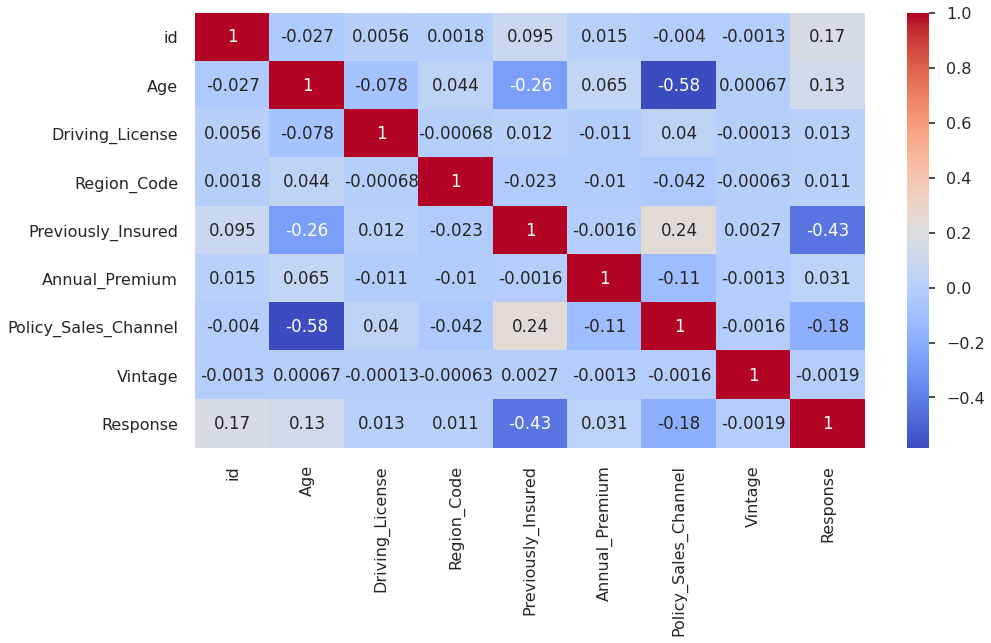

In [ ]:
#Generate a correlation matrix to check for collinearity
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

###ID

Id is a number assigned to uniquely identified the customer so this doesn't relate to the target variable i.e., wether they are interested in taking the insurance or not so we can drop this column 

In [ ]:
df.drop(['id'],axis=1,inplace=True)

###Gender

To represent Gender(male, female) in integer form  I am going to use One hot Encoding

In [ ]:
gender=pd.get_dummies(df['Gender'],drop_first=True)
df.drop(['Gender'],axis=1,inplace=True)
df = pd.concat([df,gender],axis=1)
df.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Male
0,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0,1
1,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0,1
2,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0,0
3,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0,0
4,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0,1


###Age

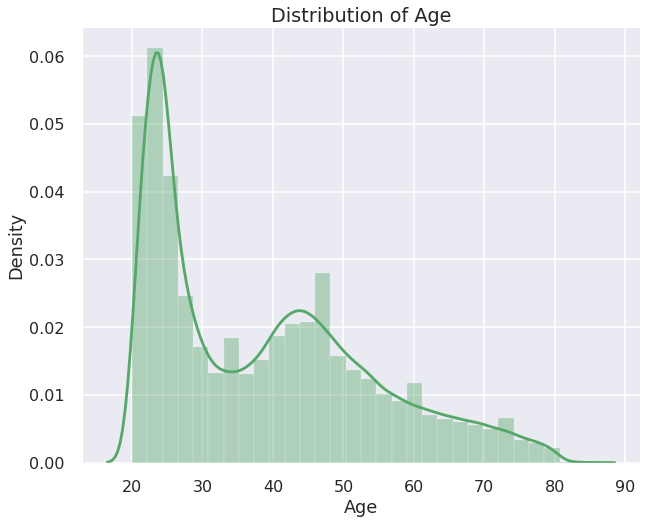

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.despine(f)
sns.distplot(df['Age'],bins=30,color="g")
plt.title('Distribution of Age')
plt.show()

In [ ]:
df['Age'].describe()

count    382154.000000
mean         38.545691
std          15.226897
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

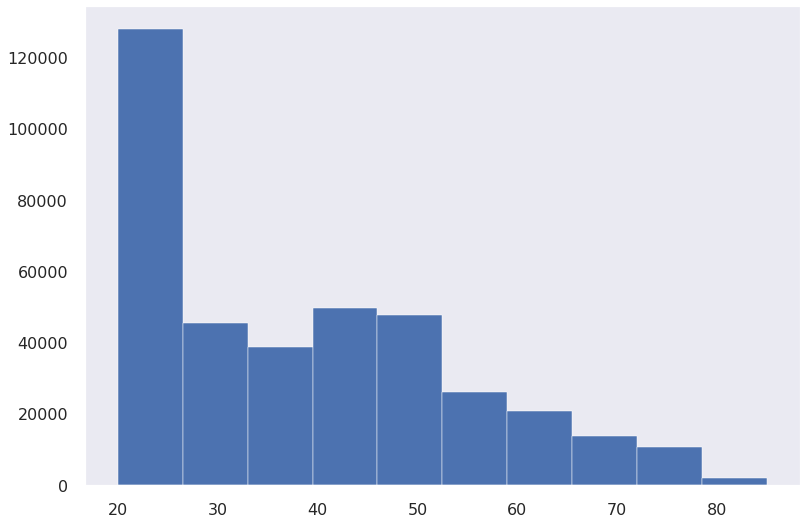

In [ ]:
df['Age'].hist(grid=False)

The vast majority of ages are between 20 and 50, I opt to create bins here to reduce the number of potential ages

In [ ]:
# Convert Age values
bins = [20, 30, 40, 50, 60, 85]

# Create Bins
df['age_bins'] = pd.cut(x=df['Age'], bins=bins, labels=['20-30', '30-40', '40-50', '50-60', '60+'])
df.drop(columns='Age', inplace=True)

In [ ]:
df['age_bins'].value_counts()

20-30    156698
40-50     78492
30-40     56913
50-60     43984
60+       40332
Name: age_bins, dtype: int64

In [ ]:
# Create 'dummy' values for each bin
age_dummies = pd.get_dummies(df['age_bins'], prefix='age_range', drop_first=True)
df = pd.concat([df, age_dummies], axis=1)
df.drop(columns='age_bins', inplace=True)

print(df.shape)
df.head()

(382154, 14)


,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Male,age_range_30-40,age_range_40-50,age_range_50-60,age_range_60+
0,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0,1,0,0,0,0
1,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0,1,0,1,0,0
2,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0,0,0,0,0,1
3,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0,0,0,0,0,0
4,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0,1,0,0,0,0


###Driving_License

In [ ]:
df['Driving_License'].value_counts()

1    381431
0       723
Name: Driving_License, dtype: int64

Less than 1% of the samples are individuals without a license. People without a drivers license would not usually be interested in vehicle insurance, therefore I'm going to check to see if any of these individuals actually have a positive response:

In [ ]:
len(df2[(df['Driving_License']  == 0) &
          (df['Response']  == 1)])

37

Because only 37 of the people without licenses are actually wanting insurance, I don't see much use for this feature without something else to go along with it. Such as a feature that asks if a person will be getting a new vehicle soon (or a drivers license). Therefore, I opt to remove it.

In [ ]:
df.drop(columns='Driving_License', inplace=True)

###Region_Code

In [ ]:
df['Region_Code'].unique()

array([ 7., 28., 33., 46., 25.,  8., 41., 39., 13., 14., 36.,  3., 43.,
       45., 48., 11., 30., 15.,  6., 50., 38., 19., 34., 22., 29., 35.,
       12., 37.,  4., 10., 40., 24., 31., 21.,  2., 52.,  9., 49.,  5.,
       47.,  1., 20., 42., 27., 26., 32., 18., 16., 17., 51.,  0., 23.,
       44.])

There are many different regions being represented in this data, the values are NOT ordinal, therefore I am going to use one hot encoding (i.e. dummy values) for each region. This will considerably add to the number of features, but should prevent any erroneaous calculations by sklearn.

In [ ]:
# Create 'dummy' values and combine them with data
rc_dummies = pd.get_dummies(df['Region_Code'], prefix='RC', drop_first=True)
df = pd.concat([df, rc_dummies], axis=1)
df.drop(columns='Region_Code', inplace=True)
df.shape

(382154, 64)

###Previously_Insured

In [ ]:
df['Previously_Insured'].value_counts()

0    195211
1    186943
Name: Previously_Insured, dtype: int64

'Previously_Insured' has a pretty even split between negative and positive responses and already has values of 0 and 1, so no further action is required on my end

###Vehicle_Age

In [ ]:
df['Vehicle_Age'].value_counts()

1-2 Year     200176
< 1 Year     166353
> 2 Years     15625
Name: Vehicle_Age, dtype: int64

There are three metrics for Vehicle_Age and they are in order so I will change the values as per the ordinal encoding for this column like:

- Between 1-2 Years : 1

- Less than 1 Year : 0

- Greater than 2 Years : 2
 

In [ ]:
df['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}, inplace=True)

###Vehicle_Damage

I am going to use one hot encoding (i.e. dummy values) for given option.

In [ ]:
df['Vehicle_Damage'].value_counts()

No     198501
Yes    183653
Name: Vehicle_Damage, dtype: int64

In [ ]:
damage = pd.get_dummies(df['Vehicle_Damage'],drop_first=True)
df.drop(['Vehicle_Damage'],axis=1,inplace=True)
df = pd.concat([df,damage],axis=1)

###Annual_Premium

In [ ]:
df['Annual_Premium'].describe()

count    382154.000000
mean      30711.271362
std       17061.595532
min        2630.000000
25%       24546.000000
50%       31692.000000
75%       39447.750000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [ ]:
df[df['Annual_Premium'] > 100000]

,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Male,age_range_30-40,age_range_40-50,age_range_50-60,age_range_60+,RC_1.0,RC_2.0,RC_3.0,RC_4.0,RC_5.0,RC_6.0,RC_7.0,RC_8.0,RC_9.0,RC_10.0,RC_11.0,RC_12.0,RC_13.0,RC_14.0,RC_15.0,RC_16.0,RC_17.0,RC_18.0,RC_19.0,RC_20.0,RC_21.0,RC_22.0,RC_23.0,RC_24.0,RC_25.0,RC_26.0,RC_27.0,RC_28.0,RC_29.0,RC_30.0,RC_31.0,RC_32.0,RC_33.0,RC_34.0,RC_35.0,RC_36.0,RC_37.0,RC_38.0,RC_39.0,RC_40.0,RC_41.0,RC_42.0,RC_43.0,RC_44.0,RC_45.0,RC_46.0,RC_47.0,RC_48.0,RC_49.0,RC_50.0,RC_51.0,RC_52.0,Yes
1956,1,0,100018.0,160.0,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2531,0,1,111876.0,26.0,78,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2815,1,1,508073.0,26.0,192,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2969,0,1,115034.0,26.0,185,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3543,1,1,100445.0,122.0,132,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378857,0,1,252866.0,26.0,57,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
379538,1,0,199154.0,160.0,184,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
380062,1,0,100981.0,152.0,122,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
381244,1,0,125490.0,152.0,299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


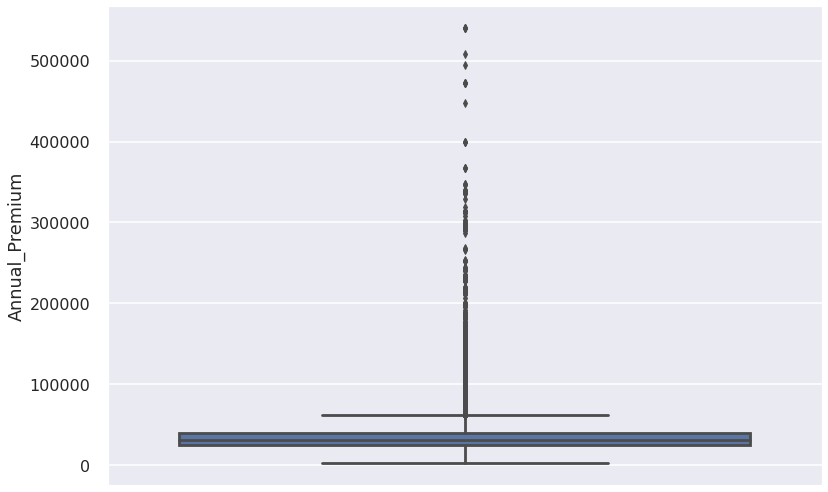

In [ ]:
sns.boxplot(y=df['Annual_Premium'], data=df)

There is a wide disburtion of annual premium amounts with the high end (>100k) being outliers. This can be handled in few ways:

- Remove the outliers (not ideal)

- Create bins for value ranges (better)

- Do nothing and scale the values

I am going to start by created the different ranges for the data like so:

- less than 30k : 0

- Between 30k and 100k : 1

- Greater than or equal to 100k: 2

In [ ]:
# Creating Bins for annual premium value ranges

# Create Ordinal Values
df.loc[df['Annual_Premium'] < 30_000, 'Annual_Premium'] = 0
df.loc[(df['Annual_Premium'] >= 30_000) & (df['Annual_Premium'] < 100_000) , 'Annual_Premium'] = 1
df.loc[df['Annual_Premium'] > 100_000, 'Annual_Premium'] = 2

# One-Hot-Encoding
yr_prem_dummies = pd.get_dummies(df['Annual_Premium'], prefix='yr_prem', drop_first=True)
df = pd.concat([df, yr_prem_dummies], axis=1)
df.drop(columns='Annual_Premium', inplace=True)
print(df.shape)

(382154, 65)


###Policy_Sales_Channel

In [ ]:
df['Policy_Sales_Channel'].unique()

array([152.,  26., 124., 122., 158., 157., 156., 160.,  24., 153.,  55.,
         1.,   8.,  88.,  13.,  11., 163., 151.,   7.,   9.,  15.,  31.,
       120.,  30., 150.,  25.,  61., 154.,  64., 155., 113., 108., 125.,
        52., 121.,  16.,  44.,  14.,  29.,   4.,  54.,   3., 111.,  60.,
        12.,  46., 103.,  42.,  65., 136., 109.,  91.,  34., 106.,  22.,
        53., 139., 127., 105.,  21., 131.,  37.,  23.,  45., 159.,  98.,
        18.,  19., 137., 145., 128., 135.,  59.,  40., 138.,  82., 116.,
       129.,  56.,  10.,   2., 107., 147.,  17.,  35.,  47., 140.,  32.,
       134.,  36.,  39., 132.,  94.,  97., 119., 148., 133., 118.,  63.,
        93.,  83.,  80.,  86.,  92., 130., 110.,  81.,  58.,  78.,  90.,
         6.,  20., 114., 115.,  68., 146.,  70., 104.,  49.,  69.,  73.,
        89.,  75.,  79.,  96.,  95.,  48.,  67.,  51.,  38.,  76., 117.,
        66.,  27.,  57., 126.,  28.,  84., 101., 100.,  87.,  99., 149.,
        62.,  74., 144.,  33., 143.,  50.,  43., 10

Similar to 'Region_Code', the 'Policy_Sales_Channel' feature is numerical but the values are NOT ordered. Therefore I will need to convert this by using one hot encoding. This will create a large number of new features.

In [ ]:
# One-Hot-Encoding
rc_dummies = pd.get_dummies(df['Policy_Sales_Channel'], prefix='PSC', drop_first=True)
df = pd.concat([df, rc_dummies], axis=1)
df.drop(columns='Policy_Sales_Channel', inplace=True)
df.shape

(382154, 219)

###Vintage

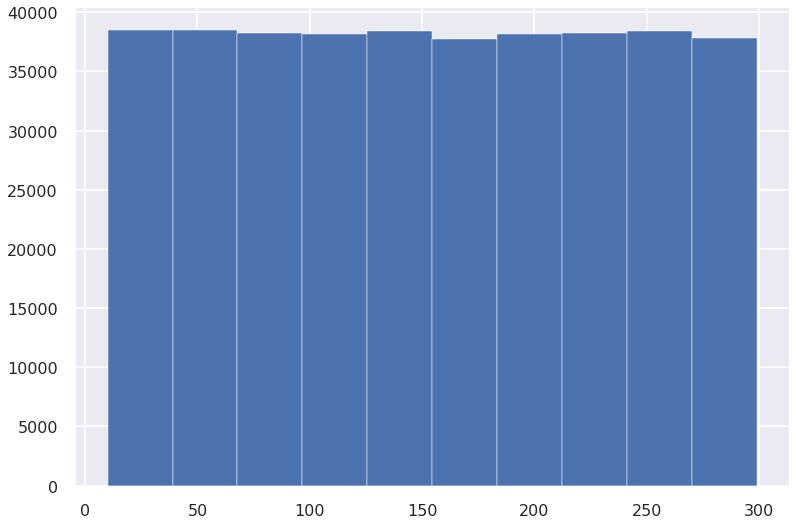

In [ ]:
df['Vintage'].hist()

Because these values are ordinal, I could just leave this featuer as-is, however because the value ranges are so evenly distributed I'm going to create bins for this as well using 50 day increments.

In [ ]:
# Create Bins
df.loc[df['Vintage'] < 50, 'Vintage'] = 1
df.loc[(df['Vintage'] >= 50) & (df['Vintage'] < 100)  , 'Vintage'] = 2
df.loc[(df['Vintage'] >= 100) & (df['Vintage'] < 150) , 'Vintage'] = 3
df.loc[(df['Vintage'] >= 150) & (df['Vintage'] < 200) , 'Vintage'] = 4
df.loc[(df['Vintage'] >= 200) & (df['Vintage'] < 250) , 'Vintage'] = 5
df.loc[(df['Vintage'] >= 250) & (df['Vintage'] < 300) , 'Vintage'] = 6

In [ ]:
df['Vintage'].value_counts()

3    66107
2    66059
5    65806
4    65567
6    65543
1    53072
Name: Vintage, dtype: int64

In [ ]:
# One-Hot-Encoding
vintage_dummies = pd.get_dummies(df['Vintage'], prefix='vintage', drop_first=True)
df = pd.concat([df, vintage_dummies], axis=1)
df.drop(columns='Vintage', inplace=True)

In [ ]:
print(df.shape)

print(df.shape)
print(df.head())

(382154, 223)
(382154, 223)
   Previously_Insured  Vehicle_Age  Response  ...  vintage_4  vintage_5  vintage_6
0                   1            0         0  ...          0          0          0
1                   0            1         0  ...          0          0          0
2                   0            1         0  ...          0          0          1
3                   0            0         0  ...          0          0          0
4                   1            0         0  ...          0          1          0

[5 rows x 223 columns]


##Visualization

In [ ]:
target = "Response"
x = [x for x in df.columns if x != target]
X = df[x]
y = df[target]

In [ ]:
## before proceeding to model training lets 
## do dimentionality reduction and plot the 
## scatter of who have bought the policy and
## who does not

from sklearn.decomposition import PCA
pca  = PCA()
pca.fit(X)

transformedFeatures = pca.transform(X)

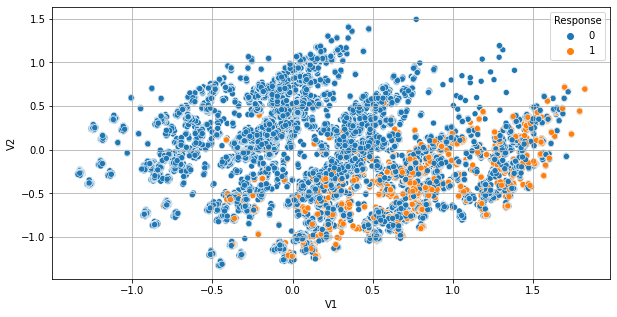

In [ ]:
## lets make this a dataFrame
dimReducedDataFrame = pd.DataFrame(transformedFeatures)
dimReducedDataFrame = dimReducedDataFrame.rename(columns = { 0: 'V1', 1 : 'V2', 2 : 'V3'})
dimReducedDataFrame['Response'] = y

## Plotting this
plt.figure(figsize = (10, 5))
sns.scatterplot(data = dimReducedDataFrame, x = 'V1', y = 'V2',hue = 'Response')
plt.grid(True)
plt.show()

Checking the corelation between columns for the last time to check if everything is fine

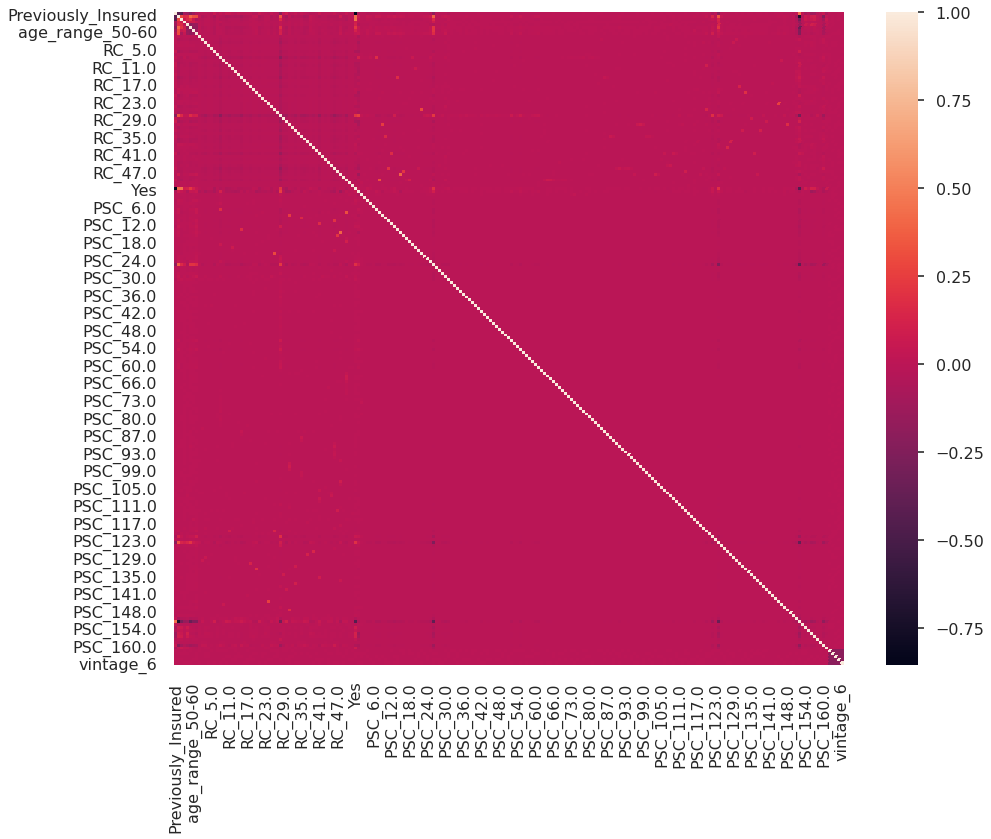

In [ ]:
df = df[[col for col in df if df[col].nunique() > 1]]

corr = df.corr()

plt.figure(figsize=(15,12))

sns.heatmap(corr)

plt.show()

##Confustion Matrix function

In [ ]:
def cnfs_matrix(y_true,y_pred):
  oof_rf_01 = np.where(y_pred > 0.5, 1, 0)
  cf_matrix = confusion_matrix(y_true, (oof_rf_01)) 
  group_names = ['False Neg','False Pos','True Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                       cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.4)
  plt.style.use('seaborn-poster')
  sns.heatmap(cf_matrix, annot= labels, fmt='', cmap='vlag_r')

In [ ]:
# split into 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 49)
  
# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (267507, 222)
Number transactions y_train dataset:  (267507,)
Number transactions X_test dataset:  (114647, 222)
Number transactions y_test dataset:  (114647,)


#Normal

##LR

###Find best Parameter for Logistic Regression model

In [ ]:
folds = KFold(n_splits = 2, shuffle = True, random_state = 10)

hyper_params = [ {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                  'C' : [0.01,0.1,1],
                  'solver' : ['Newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]


# specify model
model = LogisticRegression()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.9min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.359430,0.002915,0.000000,0.000000,0.01,l1,Newton-cg,"{'C': 0.01, 'penalty': 'l1', 'solver': 'Newton...",NaN,NaN,NaN,NaN,60,NaN,NaN,NaN,NaN
1,0.354714,0.006027,0.000000,0.000000,0.01,l1,lbfgs,"{'C': 0.01, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN
2,2.087307,0.045946,0.212140,0.013279,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.842397,0.841499,0.841948,0.000449,27,0.841716,0.842771,0.842243,0.000528
3,0.371494,0.024297,0.000000,0.000000,0.01,l1,sag,"{'C': 0.01, 'penalty': 'l1', 'solver': 'sag'}",NaN,NaN,NaN,NaN,40,NaN,NaN,NaN,NaN
4,9.198701,0.011629,0.212466,0.018195,0.01,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.843093,0.841499,0.842296,0.000797,26,0.841776,0.842801,0.842288,0.000513
5,0.374282,0.017494,0.000000,0.000000,0.01,l2,Newton-cg,"{'C': 0.01, 'penalty': 'l2', 'solver': 'Newton...",NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN
6,3.524586,0.202542,0.243993,0.020095,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844162,0.842673,0.843417,0.000744,24,0.843047,0.844281,0.843664,0.000617
7,1.120036,0.020867,0.215389,0.022971,0.01,l2,liblinear,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.844184,0.842179,0.843182,0.001002,25,0.843114,0.844633,0.843873,0.000759
8,5.360426,0.132456,0.208776,0.014917,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.844169,0.842680,0.843425,0.000744,22,0.843039,0.844319,0.843679,0.000640
9,7.385952,0.148002,0.213730,0.020730,0.01,l2,saga,"{'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}",0.844154,0.842680,0.843417,0.000737,23,0.843047,0.844304,0.843675,0.000629


In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.8440937968131985 corresponding to hyperparameters {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
# logistic regression object
lr = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga')
  
# train the model on train set
lr.fit(X_train, y_train.ravel())

# predict test data  
predictions = lr.predict(X_test)
  
# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     95603
           1       0.54      0.34      0.41     19044

    accuracy                           0.84    114647
   macro avg       0.71      0.64      0.66    114647
weighted avg       0.82      0.84      0.83    114647



0.41456166419019314
0.5386100386100386
0.8419147470060272
0.33695652173913043
0.33695652173913043


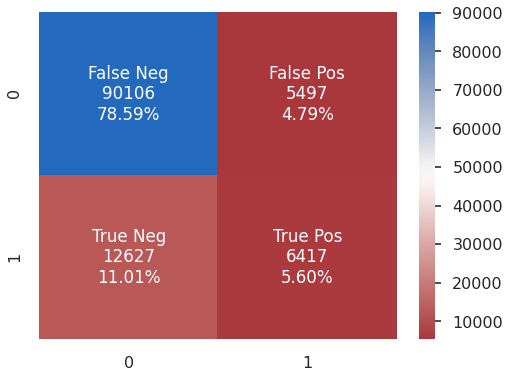

In [ ]:
print(f1_score(y_test,predictions))
print(precision_score(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions))
cnfs_matrix(y_test,predictions)

0.3350425712049328


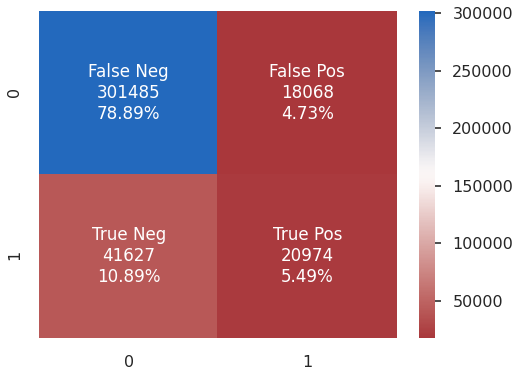

In [ ]:
predictions = lr.predict(X)
print(recall_score(y,predictions))
cnfs_matrix(y,predictions)

##GNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

modelGNB = GaussianNB()
modelGNB.fit(X_train, y_train.values.ravel())
Y_pred_GNB = modelGNB.predict(X_test)
print(classification_report(y_test, Y_pred_GNB))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75     95603
           1       0.33      0.98      0.49     19044

    accuracy                           0.66    114647
   macro avg       0.66      0.79      0.62    114647
weighted avg       0.88      0.66      0.71    114647



0.4923287815679865
0.32866394481205125
0.6640470313222326
0.9806763285024155


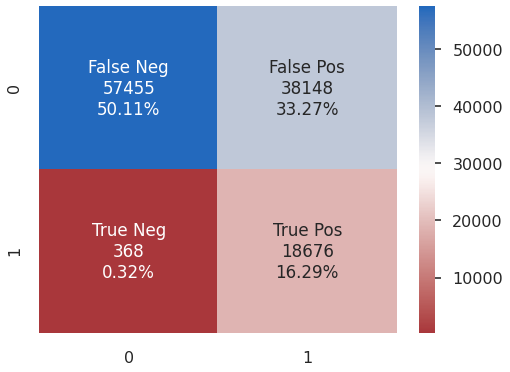

In [ ]:
print(f1_score(y_test,Y_pred_GNB))
print(precision_score(y_test,Y_pred_GNB))
print(accuracy_score(y_test,Y_pred_GNB))
print(recall_score(y_test,Y_pred_GNB))
cnfs_matrix(y_test,Y_pred_GNB)

0.9822526796696538


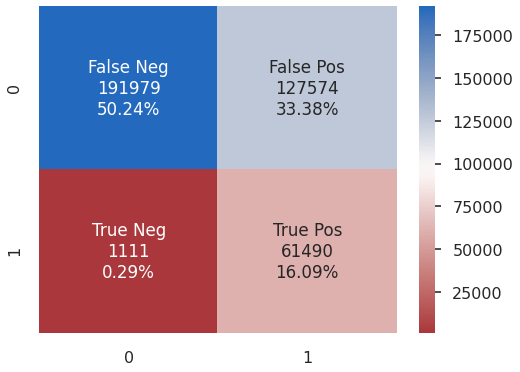

In [ ]:
Y_pred_GNB = modelGNB.predict(X)
print(recall_score(y,Y_pred_GNB))
cnfs_matrix(y,Y_pred_GNB)

##DT

###Find best Parameter for Decision Tree model

In [ ]:
folds = KFold(n_splits = 2, shuffle = True, random_state = 10)

hyper_params = [ {'criterion' : ['gini', 'entropy'],
                     'max_depth': [2,3,5,None]}]


# specify model
model = DecisionTreeClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   28.9s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.788131,0.037052,0.107846,0.000493,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.837702,0.836647,0.837174,0.000528,2,0.836647,0.837702,0.837174,0.000528
1,0.928424,0.000277,0.109793,0.004902,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.837695,0.836647,0.837171,0.000524,5,0.836759,0.837702,0.837230,0.000472
2,1.259960,0.007475,0.108650,0.001950,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.838442,0.836624,0.837533,0.000909,1,0.837491,0.837739,0.837615,0.000124
3,3.397814,0.183813,0.143672,0.001958,gini,None,"{'criterion': 'gini', 'max_depth': None}",0.831422,0.829843,0.830632,0.000789,7,0.897341,0.899764,0.898552,0.001212
4,0.752677,0.002994,0.105539,0.000230,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.837702,0.836647,0.837174,0.000528,2,0.836647,0.837702,0.837174,0.000528
5,0.918125,0.004146,0.106887,0.000619,entropy,3,"{'criterion': 'entropy', 'max_depth': 3}",0.837702,0.836647,0.837174,0.000528,2,0.836647,0.837702,0.837174,0.000528
6,1.266073,0.002369,0.109922,0.000060,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.837672,0.836602,0.837137,0.000535,6,0.836669,0.837732,0.837201,0.000531
7,3.255781,0.305696,0.143308,0.000008,entropy,None,"{'criterion': 'entropy', 'max_depth': None}",0.831317,0.829551,0.830434,0.000883,8,0.897341,0.899764,0.898552,0.001212


In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.8375332200316449 corresponding to hyperparameters {'criterion': 'gini', 'max_depth': 5}


In [ ]:
modelDT = DecisionTreeClassifier(max_depth=5)
modelDT.fit(X_train, y_train.values.ravel())
Y_pred_DT = modelDT.predict(X_test)
print(classification_report(y_test, Y_pred_DT))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     95603
           1       0.59      0.01      0.03     19044

    accuracy                           0.83    114647
   macro avg       0.71      0.51      0.47    114647
weighted avg       0.79      0.83      0.76    114647



0.025482942868886152
0.5904761904761905
0.8345530192678395
0.013022474270111321


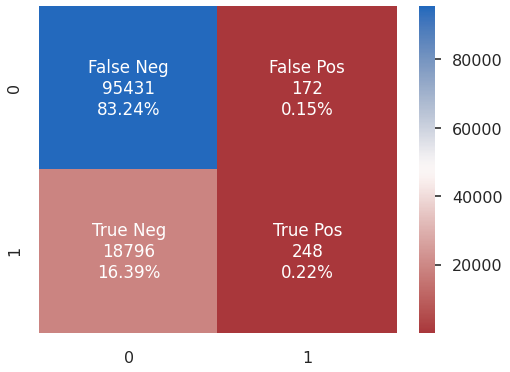

In [ ]:
print(f1_score(y_test,Y_pred_DT))
print(precision_score(y_test,Y_pred_DT))
print(accuracy_score(y_test,Y_pred_DT))
print(recall_score(y_test,Y_pred_DT))
cnfs_matrix(y_test,Y_pred_DT)

0.013258574144183001


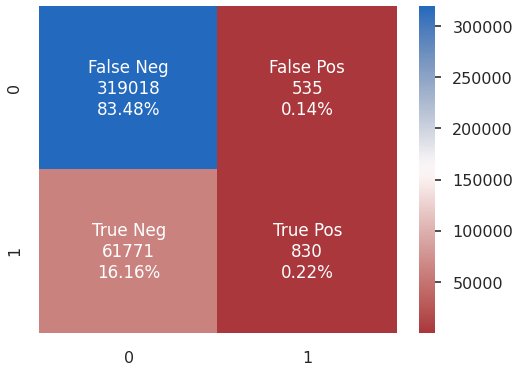

In [ ]:
Y_pred_DT = modelDT.predict(X)
print(recall_score(y,Y_pred_DT))
cnfs_matrix(y,Y_pred_DT)

##RF

###Find best Parameter for Random Forest Classifier model 

In [ ]:
folds = KFold(n_splits = 2, shuffle = True, random_state = 10)

hyper_params = [{'n_estimators' : [30,50,100]}]


# specify model
model = RandomForestClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,10.497786,0.000837,1.506327,0.024887,30,{'n_estimators': 30},0.834323,0.833237,0.833780,0.000543,3,0.897012,0.899345,0.898178,0.001167
1,16.831312,0.330633,2.398272,0.060193,50,{'n_estimators': 50},0.834255,0.833783,0.834019,0.000236,2,0.897221,0.899696,0.898459,0.001238
2,33.561552,0.303462,4.779732,0.021462,100,{'n_estimators': 100},0.835302,0.833626,0.834464,0.000838,1,0.897326,0.899764,0.898545,0.001219


In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.8344641417309451 corresponding to hyperparameters {'n_estimators': 100}


In [ ]:
modelRFC = RandomForestClassifier(n_estimators=100)
modelRFC.fit(X_train, y_train.values.ravel())
Y_pred_RFC = modelRFC.predict(X_test)
print(classification_report(y_test, Y_pred_RFC))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     95603
           1       0.50      0.40      0.44     19044

    accuracy                           0.83    114647
   macro avg       0.69      0.66      0.67    114647
weighted avg       0.82      0.83      0.83    114647



0.443362960804313
0.4981337175037653
0.8333929365792389
0.39944339424490655


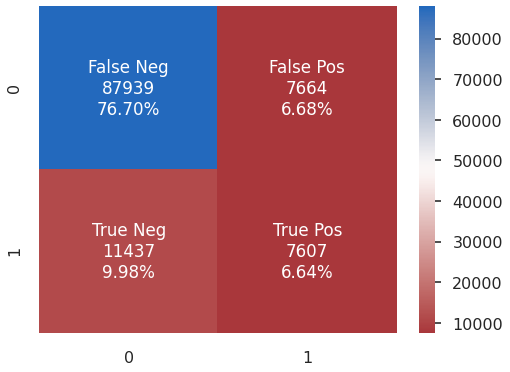

In [ ]:
print(f1_score(y_test,Y_pred_RFC))
print(precision_score(y_test,Y_pred_RFC))
print(accuracy_score(y_test,Y_pred_RFC))
print(recall_score(y_test,Y_pred_RFC))
cnfs_matrix(y_test,Y_pred_RFC)

0.5203111771377454


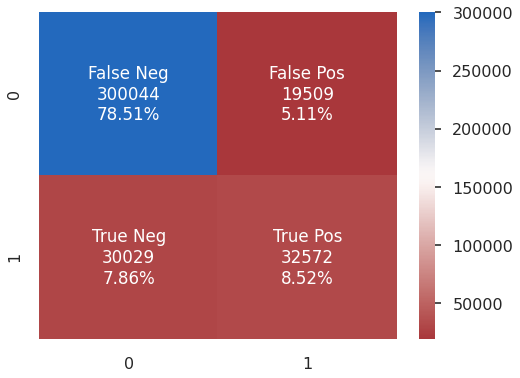

In [ ]:
Y_pred_RFC = modelRFC.predict(X)
print(recall_score(y,Y_pred_RFC))
cnfs_matrix(y,Y_pred_RFC)

#SMOTE

Advantages and Disadvantage of over-sampling

**Advantages**
- This method leads to no information loss compared to Undersampling .

**Disadvantages**
- It increases the likelihood of overfitting since it replicates the minority class events.

***We will be generating synthetic minority class data of the training example and later predict on test set as our goal is to perfom well in future data***

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 43557
Before OverSampling, counts of label '0': 223950 

After OverSampling, the shape of train_X: (447900, 222)
After OverSampling, the shape of train_y: (447900,) 

After OverSampling, counts of label '1': 223950
After OverSampling, counts of label '0': 223950


##LR

In [ ]:
lr1 = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga')
lr1.fit(X_train_res, y_train_res.ravel())
predictions = lr1.predict(X_test)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86     95603
           1       0.43      0.89      0.58     19044

    accuracy                           0.79    114647
   macro avg       0.70      0.83      0.72    114647
weighted avg       0.88      0.79      0.81    114647



0.5809230133163361
0.4322779130880656
0.78780953710084
0.885370720436883


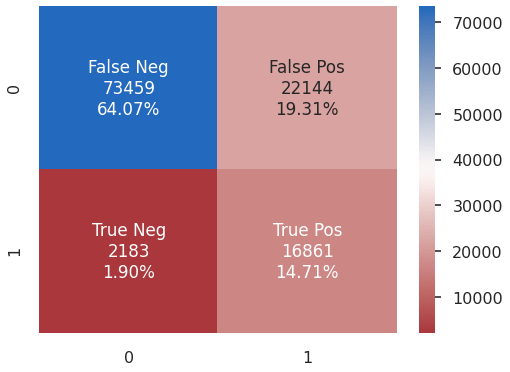

In [ ]:
print(f1_score(y_test,predictions))
print(precision_score(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions))
cnfs_matrix(y_test,predictions)

0.8882126483602498


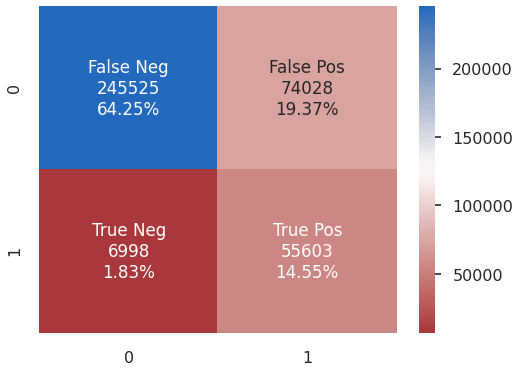

In [ ]:
predictions = lr1.predict(X)
print(recall_score(y,predictions))
cnfs_matrix(y,predictions)

##GNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

modelGNB1 = GaussianNB()
modelGNB1.fit(X_train_res, y_train_res.ravel())
Y_pred_GNB1 = modelGNB1.predict(X_test)
print(classification_report(y_test, Y_pred_GNB1))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     95603
           1       0.34      0.95      0.50     19044

    accuracy                           0.68    114647
   macro avg       0.66      0.79      0.63    114647
weighted avg       0.88      0.68      0.72    114647



0.49694996854227635
0.33599038283706306
0.6791891632576518
0.9539487502625499


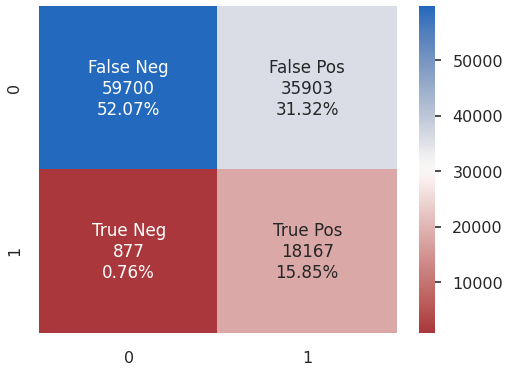

In [ ]:
print(f1_score(y_test,Y_pred_GNB1))
print(precision_score(y_test,Y_pred_GNB1))
print(accuracy_score(y_test,Y_pred_GNB1))
print(recall_score(y_test,Y_pred_GNB1))
cnfs_matrix(y_test,Y_pred_GNB1)

0.9549687704669254


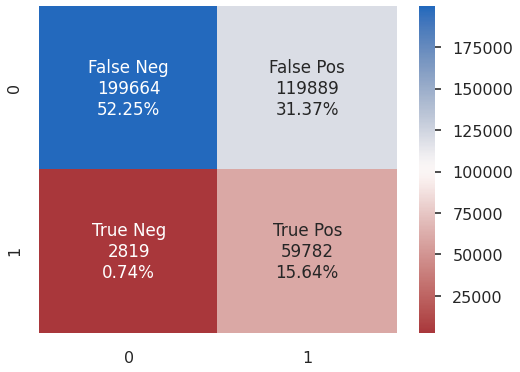

In [ ]:
Y_pred_GNB1 = modelGNB1.predict(X)
print(recall_score(y,Y_pred_GNB1))
cnfs_matrix(y,Y_pred_GNB1)

##DT

In [ ]:
modelDT1 = DecisionTreeClassifier(max_depth=5)
modelDT1.fit(X_train_res, y_train_res.ravel())
Y_pred_DT1 = modelDT1.predict(X_test)
print(classification_report(y_test, Y_pred_DT1))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     95603
           1       0.40      0.94      0.56     19044

    accuracy                           0.76    114647
   macro avg       0.69      0.83      0.70    114647
weighted avg       0.89      0.76      0.79    114647



0.5634217826747959
0.40157286802654213
0.7570368173611172
0.9438143247216971


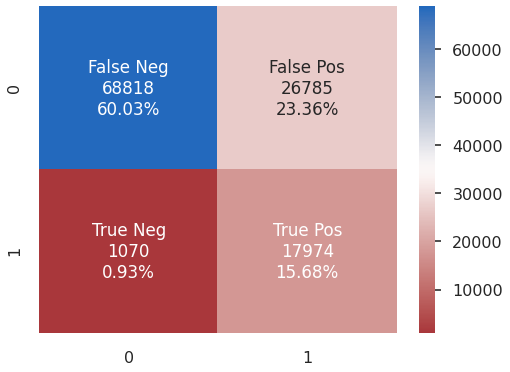

In [ ]:
print(f1_score(y_test,Y_pred_DT1))
print(precision_score(y_test,Y_pred_DT1))
print(accuracy_score(y_test,Y_pred_DT1))
print(recall_score(y_test,Y_pred_DT1))
cnfs_matrix(y_test,Y_pred_DT1)

0.9443778853372949


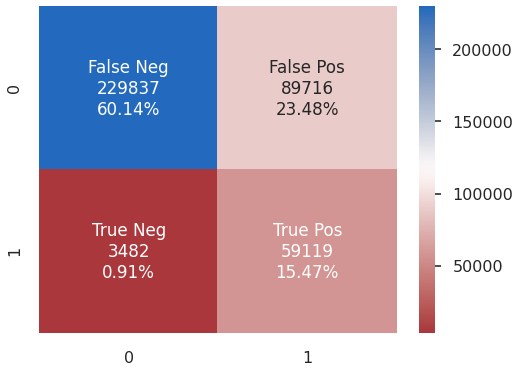

In [ ]:
Y_pred_DT1 = modelDT1.predict(X)
print(recall_score(y,Y_pred_DT1))
cnfs_matrix(y,Y_pred_DT1)

##RF

In [ ]:
modelRFC1 = RandomForestClassifier(n_estimators=100)
modelRFC1.fit(X_train_res, y_train_res.ravel())
Y_pred_RFC1 = modelRFC1.predict(X_test)
print(classification_report(y_test, Y_pred_RFC1))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     95603
           1       0.43      0.79      0.55     19044

    accuracy                           0.79    114647
   macro avg       0.69      0.79      0.71    114647
weighted avg       0.86      0.79      0.81    114647



0.5532150163100569
0.4261862168838913
0.7885422209041667
0.7881222432262129


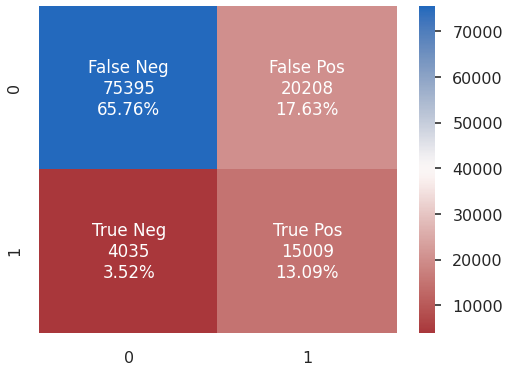

In [ ]:
print(f1_score(y_test,Y_pred_RFC1))
print(precision_score(y_test,Y_pred_RFC1))
print(accuracy_score(y_test,Y_pred_RFC1))
print(recall_score(y_test,Y_pred_RFC1))
cnfs_matrix(y_test,Y_pred_RFC1)

0.8826057091739749


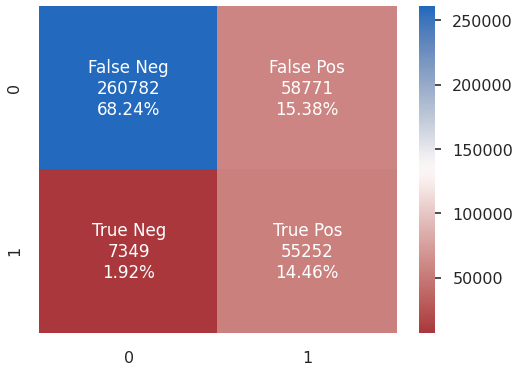

In [ ]:
Y_pred_RFC1 = modelRFC1.predict(X)
print(recall_score(y,Y_pred_RFC1))
cnfs_matrix(y,Y_pred_RFC1)

#Random Under sampler

Advantage and disadvantages of Under-sampling

**Advantages**

- It can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.

**Disadvantages**

- It can discard potentially useful information which could be important for building rule classifiers.
- The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. Thereby, resulting in inaccurate results with the actual test data set.

***We will be Randomly delete majority class data of the training example and later predict on test set as our goal is to perfom well in future data***

In [ ]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  

rus = RandomUnderSampler()
  
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_rus.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_rus.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_rus == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_rus == 0)))

Before Undersampling, counts of label '1': 43557
Before Undersampling, counts of label '0': 223950 

After Undersampling, the shape of train_X: (87114, 222)
After Undersampling, the shape of train_y: (87114,) 

After Undersampling, counts of label '1': 43557
After Undersampling, counts of label '0': 43557


##LR

In [ ]:
lr4 = LogisticRegression(C = 1, penalty = 'l1', solver = 'saga')
lr4.fit(X_train_rus, y_train_rus.ravel())
predictions = lr4.predict(X_test)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     95603
           1       0.42      0.93      0.58     19044

    accuracy                           0.78    114647
   macro avg       0.70      0.84      0.71    114647
weighted avg       0.89      0.78      0.80    114647



0.5787447369714445
0.42059769020121446
0.7757202543459488
0.9274837219071623


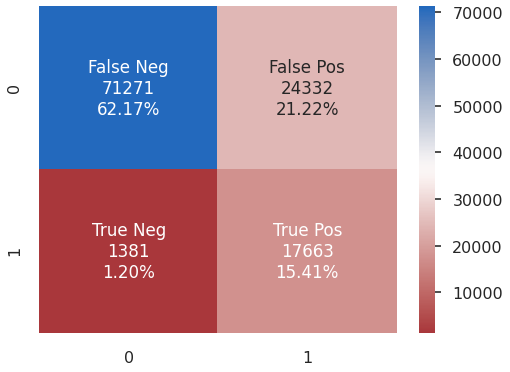

In [ ]:
print(f1_score(y_test,predictions))
print(precision_score(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(recall_score(y_test,predictions))
cnfs_matrix(y_test,predictions)

0.9276049903356176


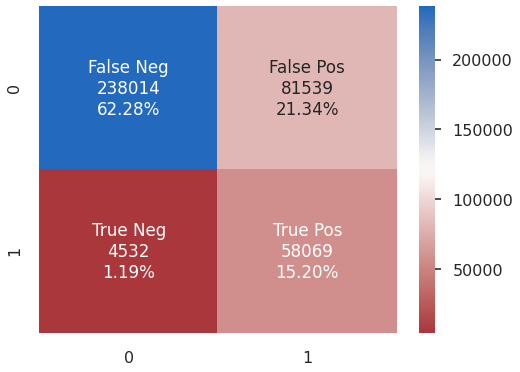

In [ ]:
predictions = lr4.predict(X)
print(recall_score(y,predictions))
cnfs_matrix(y,predictions)

##Guassian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

modelGNB4 = GaussianNB()
modelGNB4.fit(X_train_rus, y_train_rus.ravel())
Y_pred_GNB4 = modelGNB4.predict(X_test)
print(classification_report(y_test, Y_pred_GNB4))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78     95603
           1       0.35      0.96      0.51     19044

    accuracy                           0.69    114647
   macro avg       0.67      0.80      0.64    114647
weighted avg       0.88      0.69      0.73    114647



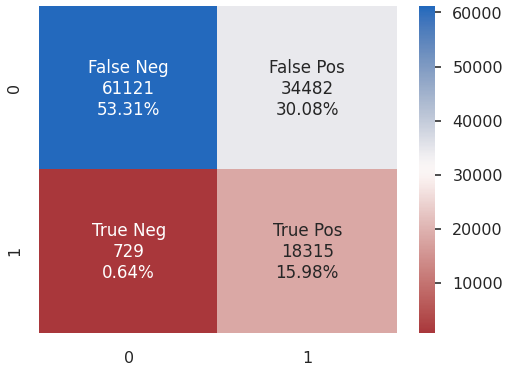

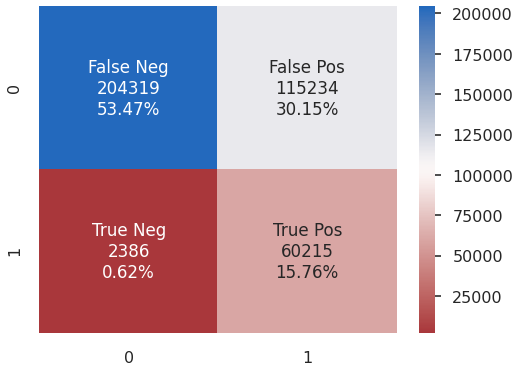

In [ ]:
cnfs_matrix(y_test,Y_pred_GNB4)
Y_pred_GNB4 = modelGNB4.predict(X)
cnfs_matrix(y,Y_pred_GNB4)

In [ ]:
print(f1_score(y,Y_pred_GNB4))
print(precision_score(y,Y_pred_GNB4))
print(accuracy_score(y,Y_pred_GNB4))
print(recall_score(y,Y_pred_GNB4))

0.5059021214030666
0.34320514793472745
0.692218320362995
0.9618855928819029


##Random Forest

In [ ]:
modelRFC4 = RandomForestClassifier(n_estimators=100)
modelRFC4.fit(X_train_rus, y_train_rus.ravel())
Y_pred_RFC4 = modelRFC4.predict(X_test)
print(classification_report(y_test, Y_pred_RFC4))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     95603
           1       0.41      0.88      0.56     19044

    accuracy                           0.77    114647
   macro avg       0.69      0.82      0.71    114647
weighted avg       0.88      0.77      0.80    114647



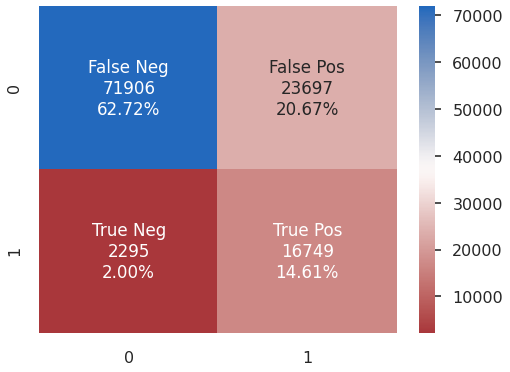

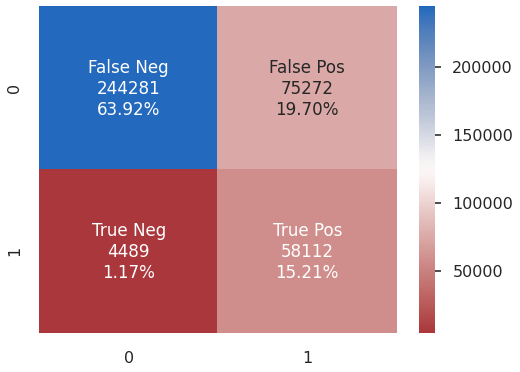

In [ ]:
cnfs_matrix(y_test,Y_pred_RFC4)
Y_pred_RFC4 = modelRFC4.predict(X)
cnfs_matrix(y,Y_pred_RFC4)

In [ ]:
print(f1_score(y,Y_pred_RFC4))
print(precision_score(y,Y_pred_RFC4))
print(accuracy_score(y,Y_pred_RFC4))
print(recall_score(y,Y_pred_RFC4))

0.5930249764012552
0.4356744437113897
0.7912857120427891
0.9282918803214006


##DT

In [ ]:
modelDT4 = DecisionTreeClassifier(max_depth=5)
modelDT4.fit(X_train_rus, y_train_rus.ravel())
Y_pred_DT4 = modelDT4.predict(X_test)
print(classification_report(y_test, Y_pred_DT4))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     95603
           1       0.40      0.94      0.56     19044

    accuracy                           0.76    114647
   macro avg       0.69      0.83      0.70    114647
weighted avg       0.89      0.76      0.79    114647



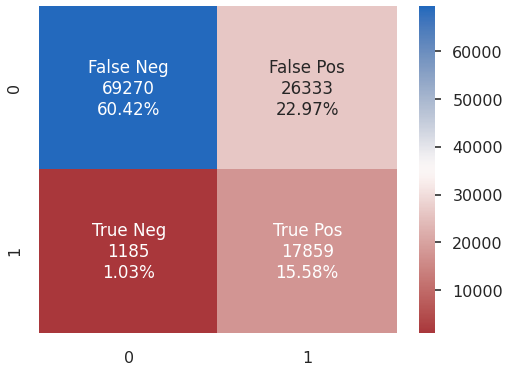

In [ ]:
cnfs_matrix(y_test,Y_pred_DT4)

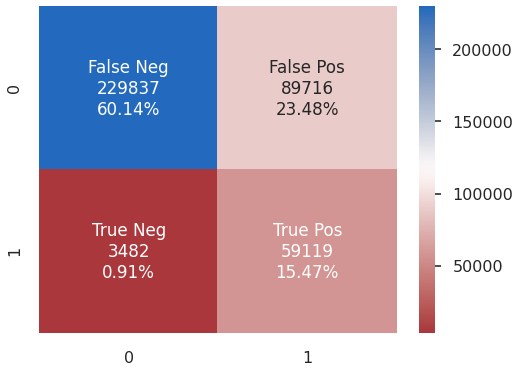

In [ ]:
Y_pred_DT4 = modelDT1.predict(X)
cnfs_matrix(y,Y_pred_DT4)

In [ ]:
print(f1_score(y,Y_pred_DT4))
print(precision_score(y,Y_pred_DT4))
print(accuracy_score(y,Y_pred_DT4))
print(recall_score(y,Y_pred_DT4))

0.5592141357195559
0.39721167736083585
0.7561244943138107
0.9443778853372949


#Comaprison

##Oversample Method

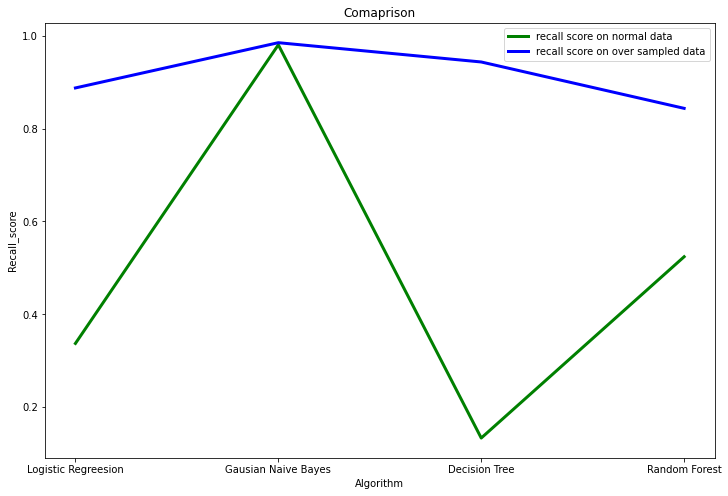

In [ ]:
plt.figure(figsize=(12, 8))
Normal = [.337,0.981,0.133,0.524]
OverSample = [0.888,0.9856,0.944,0.844]
epochs = ['Logistic Regreesion','Gausian Naive Bayes','Decision Tree','Random Forest']
plt.plot(epochs,Normal,'g',label='recall score on normal data',linewidth=3)
plt.plot(epochs,OverSample,'b',label='recall score on over sampled data',linewidth=3)
plt.title('Comaprison')
plt.xlabel('Algorithm')
plt.ylabel('Recall_score')
plt.legend()
plt.legend()
plt.show()

###Observation

***We can say the Guassian Naive Bayes algorithm doesn't need oversampling of data as it performs quite well in the imbalanace class data which can be verified from the data visualization where as the other algorithm like Logistic reegression, Decision Tree, Random Forest Classfier gives poor accuracy on the imbalace data but performance improves significantly after trainig from oversampled data.***

##Undersample Method

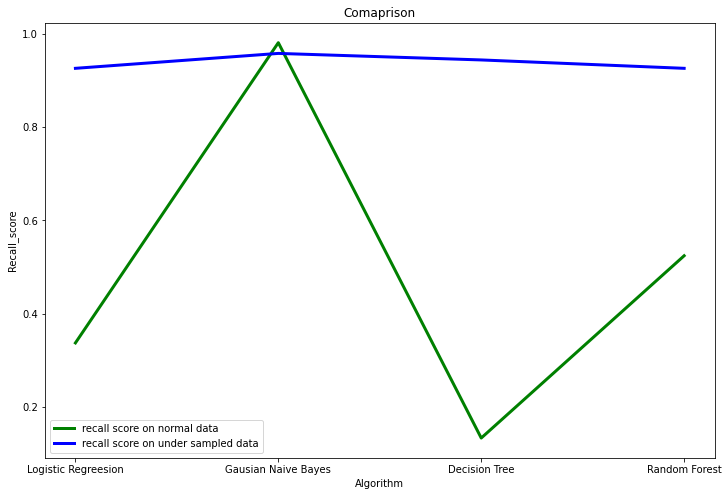

In [ ]:
plt.figure(figsize=(12, 8))
Normal = [.337,0.981,0.133,0.524]
UnderSample = [0.926,0.958,0.944,0.926]
epochs = ['Logistic Regreesion','Gausian Naive Bayes','Decision Tree','Random Forest']
plt.plot(epochs,Normal,'g',label='recall score on normal data',linewidth=3)
plt.plot(epochs,UnderSample,'b',label='recall score on under sampled data',linewidth=3)
plt.title('Comaprison')
plt.xlabel('Algorithm')
plt.ylabel('Recall_score')
plt.legend()
plt.legend()
plt.show()

###Observation

***We can say the Guassian Naive Bayes algorithm doesn't need undersampling of data as it performs quite well in the imbalanace class data which can be verified from the data visualization section. Where as the other algorithm like Logistic reegression, Decision Tree, Random Forest Classfier gives poor accuracy on the imbalace data but performance improves significantly after trainig from undersampled data.***